<a href="https://colab.research.google.com/github/GerardoToso/Competencia-FSadosky-e-YPF-/blob/main/04_Whole_population_light_gbm_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table style="float:left; border:none">
   <tr style="border:none">
       <td style="border:none">  
           <img 
               src="" 
               style="width:10px"
           >
           </a>    
       </td>
   </tr>
</table>
<div style="float:right;"><h2>04. Whole population light gbm classifier</h2></div>

 <a id="top"></a> <br>
## Índice
1. [Entradas y Entregable](#1)<br>
    1.1. [Entradas del modelo](#11)<br>
    1.2. [Entregable](#12)<br>
2. [Carga de paquetes y datos](#2)<br>
    2.1. [Librerías y clases](#21)<br>
    2.2. [Lectura de datos](#22)<br>
    2.3. [Eliminación de valores nulos](#23)<br>
    2.4. [Binarización de variable delta_WHP](#24)<br>
    2.5. [Separación en train y test](#25)<br>
3. [Modelo](#3)<br>
    3.1. [Confección pipeline](#31)<br>
    3.2. [Optimización de hiperparámetros](#32)<br>
    3.3. [Entrenamiento del modelo](#33)<br>
    3.4. [Mejores Hiperparámetros](#34)<br>
4. [Evaluación del modelo](#4)<br>
    4.1. [Cálculo de métricas](#41)<br>
    4.2. [Matriz de confusión](#42)<br>
    4.3. [ROC Curve](#43)<br>
    4.4. [Precision-Recall curve](#44)<br>

***
<a id="1"></a> <br>
## 1. Entradas y Entregable

<a id="11"></a>
### 1.1. Entradas

|Tipo|Nombre|Descripción|Ubicación Lab|
|:-------|----------------|---------------------------------------------------|-------------------------------------|
|**csv**| `Dataset participantes.csv` | datos relacionados con los pozos al producirse una interferencia por la estimulación de un pozo hijo |`/content/drive/MyDrive/DataScience/TRABAJOS PARTICULARES/YPF/DATASET/`|

<a id="12"></a>
### 1.2. Entregable

**Archivo csv con las estimaciones de delta_WHP**

***
<a id="2"></a> <br>
## 2. Carga de paquetes y datos

<a id="21"></a>
### 2.1. Librerías y clases

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import precision_score, confusion_matrix, roc_curve, average_precision_score, precision_recall_curve, plot_precision_recall_curve
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import lightgbm as lgb

import chardet

import warnings
warnings.filterwarnings("ignore")

In [24]:
# Esta clase permite dropear columnas de un DataFrame dentro de un pipeline

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self  

<a id="22"></a> <br>
### 2.2. Lectura de datos

In [25]:
# Detección automática de la codificación de los caracteres
with open("/content/drive/MyDrive/DataScience/TRABAJOS PARTICULARES/YPF/DATASET/Dataset participantes.csv", 'rb') as f:
    enc = chardet.detect(f.read())  # or readline if the file is large

# Lectura del csv
df = pd.read_csv("/content/drive/MyDrive/DataScience/TRABAJOS PARTICULARES/YPF/DATASET/Dataset participantes.csv", sep = "\t",encoding = enc['encoding'], index_col=0)

df.sample(5)

,ID_EVENTO,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D3D,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,delta_WHP,ESTADO
ID_FILA,,,,,,,,,,,,,,,,
18980,Pozo 549-Pozo 377-32,Campo E,OIL,PAD-84,Pozo 549,32,Pozo 377,1474.508531,1474.482040,-8.838649,256.446487,4,NO,61.4,0.0,Cerrado
19723,Pozo 405-Pozo 239-10,Campo F,OIL,PAD-60,Pozo 405,10,Pozo 239,649.107037,649.054152,-8.285725,128.512140,0,NO,93.3,3.7,Cerrado
13289,Pozo 64-Pozo 61-34,Campo D,OIL,PAD-45,Pozo 64,34,Pozo 61,1032.930970,1032.777775,17.789247,307.997044,0,NO,199.6,0.0,Abierto
9939,Pozo 30-Pozo 21-39,Campo B,OIL,PAD-6,Pozo 30,39,Pozo 21,1508.466944,1508.456659,5.570267,323.046453,0,NO,77.7,0.0,Abierto
11830,Pozo 63-Pozo 190-34,Campo D,OIL,PAD-45,Pozo 63,34,Pozo 190,1147.756255,1147.746840,-4.648790,110.126619,2,NO,119.2,0.0,Abierto


In [26]:
# Se cambia el tipo de datos de variables categóricas nominales de object a category
df = df.astype({"CAMPO": "category", "FLUIDO": "category", "PAD_HIJO": "category", "HIJO": "category",
                "ETAPA_HIJO": "category", "PADRE": "category", "LINEAMIENTO": "category", "ESTADO": "category"})
df.dtypes

ID_EVENTO        object
CAMPO          category
FLUIDO         category
PAD_HIJO       category
HIJO           category
ETAPA_HIJO     category
PADRE          category
D3D             float64
D2D             float64
DZ              float64
AZ              float64
#_BARRERAS        int64
LINEAMIENTO    category
WHP_i           float64
delta_WHP       float64
ESTADO         category
dtype: object

<a id="23"></a> <br>
### 2.3. Eliminación de valores nulos
**Dado que el modelo a desarrollar en el presente notebook será tomado como baseline, se eliminan los valores nulos para mayor practicidad**

In [27]:
print("Cantidad de instancias totales =", df.shape[0])
# Eliminación de todos los valores nulos de dataset
df.dropna(inplace=True)
print("Cantidad de instancias sin valores nulos =", df.shape[0])

Cantidad de instancias totales = 26178
Cantidad de instancias sin valores nulos = 25929


<a id="24"></a> <br>
### 2.4. Binarización de variable delta_WHP

In [28]:
# Se crea una nueva variable en donde se asigna valor 0 cuando delta_WHP = 0 y valor 1 cuando delta_WHP != 0
df["delta_WHP_binarized"] = df["delta_WHP"].apply(lambda val: 1 if val != 0 else 0)

<a id="25"></a> <br>
### 2.5. Separación en train y test

In [29]:
# Selección de variable target
y = df.delta_WHP_binarized
# Selección de features
X = df.drop(["delta_WHP_binarized"], axis = 1)

# Separación en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,  stratify= y, random_state = 161)

# Verificación de distribución de variable targuet en train y test
print("Instancias de train \n", X_train.shape[0])
print("Instancias de test \n", X_test.shape[0])

Instancias de train 
 19446
Instancias de test 
 6483


***
<a id="#3"></a> <br>
## 3. Modelo

<a id="31"></a> <br>
### 3.1. Confección pipeline

In [30]:
# Instanciado de estimador
light_gbm_class = lgb.LGBMClassifier(random_state = 45)

# Instanciado de pipeline
pipe = Pipeline([ ("ColumnDropper", ColumnDropper(["ID_EVENTO", "delta_WHP"])),
                  
                  ("column_transformer",ColumnTransformer([
                                        ("standard_scaler", StandardScaler(), 
                    ["D3D", "D2D", "DZ", "AZ", "WHP_i", "#_BARRERAS"])])),
                                 
                                 ("light_gbm_class", light_gbm_class)])

<a id="32"></a> <br>
### 3.2. Optimización de hiperparámetros

In [31]:
# Optimización de hiperparámetros del modelo con grid search y cross validation

kfolds=StratifiedKFold(n_splits=3,shuffle=True, random_state=42)

params_grid = { 
                "light_gbm_class__max_depth" : [10, 100, 200],
                "light_gbm_class__learning_rate": [0.005, 0.01, 0.1],
                "light_gbm_class__n_estimators" : [10, 100, 500, 1000]
               }

model = GridSearchCV (pipe, params_grid,cv=kfolds, n_jobs = -1, scoring = "precision", refit = True)

<a id="33"></a> <br>
### 3.3. Entrenamiento del modelo

In [32]:
# Seteado de parámetros de entrenamiento
fit_params={"light_gbm_class__categorical_feature": "auto" }

# Entrenamiento del modelo
model.fit(X_train,y_train, **fit_params)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('ColumnDropper',
                                        ColumnDropper(columns=['ID_EVENTO',
                                                               'delta_WHP'])),
                                       ('column_transformer',
                                        ColumnTransformer(transformers=[('standard_scaler',
                                                                         StandardScaler(),
                                                                         ['D3D',
                                                                          'D2D',
                                                                          'DZ',
                                                                          'AZ',
                                                                          'WHP_i',
                                                              

<a id="34"></a> <br>
### 3.4. Mejores hiperparámetros

In [33]:
# Mejores hiperparámetros obtenidos por cross validation y grid search

model.best_params_

{'light_gbm_class__learning_rate': 0.01,
 'light_gbm_class__max_depth': 50,
 'light_gbm_class__n_estimators': 100}

***
<a id="#4"></a> <br>
## 4. Evaluación del modelo

<a id="41"></a> <br>
### 4.1. Cálculo de métricas

In [34]:
precision_train = precision_score(y_train, model.predict(X_train))
print("Precision train = ", precision_train)
precision_test = precision_score(y_test, model.predict(X_test))
print("Precision test = ", precision_test)

Precision train =  0.9186915887850468
Precision test =  0.8980169971671388


<a id="42"></a> <br>
### 4.2. Matriz de confusión

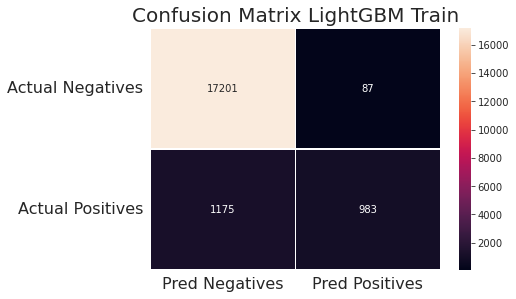

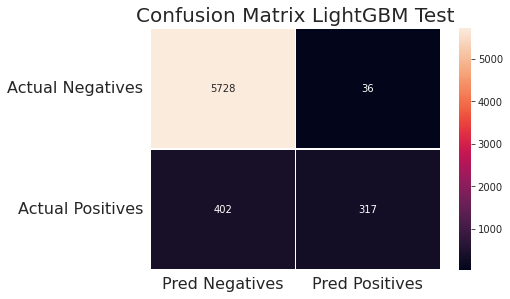

In [35]:
# Matriz de confusión para modelo
conf_matrix = confusion_matrix(y_train,  model.predict(X_train))
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix LightGBM Train", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=16, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=16, rotation=360)
plt.show()

conf_matrix = confusion_matrix(y_test,  model.predict(X_test))
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix LightGBM Test", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=16, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=16, rotation=360)
plt.show()

<a id="43"></a> <br>
### 4.3. ROC Curve

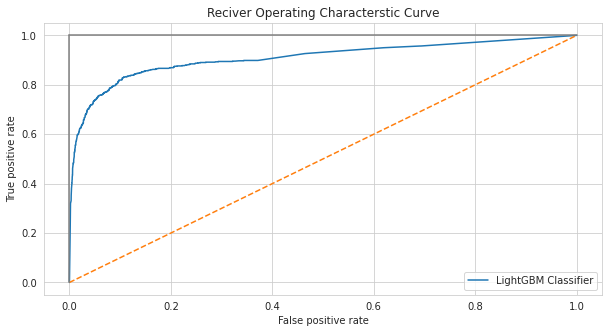

In [36]:
# Obtencion de predicciones para graficar curva ROC
probsdmodel = model.predict_proba(X_test)
predsdmodel = probsdmodel[:,1]

lr_false_positive_rate,lr_true_positive_rate,lr_threshold = roc_curve(y_test,predsdmodel)


# Grafico curva ROC
sns.set_style('whitegrid')
plt.figure(figsize=(10,5))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(lr_false_positive_rate,lr_true_positive_rate,label='LightGBM Classifier')

plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()

<a id="44"></a> <br>
### 4.4. Precision-Recall Curve

0.7471644637172625


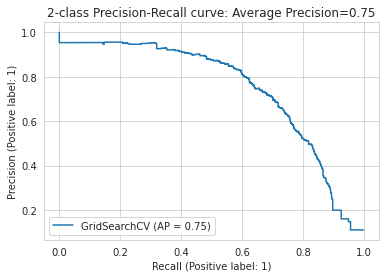

In [37]:
# Curva Precision-Recall
average_precision = average_precision_score(y_test, predsdmodel)

print(average_precision)

disp = plot_precision_recall_curve(model, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'Average Precision={0:0.2f}'.format(average_precision));